# 1. Setting up Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import torch
import torch.nn
import matplotlib.pyplot as plt
import meld.recon as recon
from meld.util import getAbs, getPhase
# local
import mri
import hqs
import model
import dataloader
import lib_complex as cp

# Setup device
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

np_dtype = np.float32

In [2]:
datapath = '/mikQNAP/dataset_train_full.h5'
dataset = dataloader.dataloader(datapath, 
                                num_batches = 2,
                                batch_size = 1,
                                noise_std = 1e-5)
meas, maps, masks, imgs = dataset[1]
imgs_0 = torch.tensor(cp.c2r(imgs).astype(np_dtype), device=device)
maps_0 = torch.tensor(cp.c2r(maps).astype(np_dtype), device=device)
meas_0 = torch.tensor(cp.c2r(meas).astype(np_dtype), device=device)
mask_0 = torch.tensor(masks.astype(np_dtype), device=device)

/home/kellman/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


(1, 256, 232) (1, 12, 256, 232) (1, 256, 232)
(1, 12, 256, 232)


In [3]:
out = mri.maps_forw(imgs_0, maps_0)
print(imgs_0[:,None,:,:].shape, maps_0.shape, out.shape)

torch.Size([1, 1, 256, 232, 2]) torch.Size([1, 12, 256, 232, 2]) torch.Size([1, 12, 256, 232, 2])


## Setup Model

In [4]:
mri_model = mri.MultiChannelMRI(device = device)
adjoint = mri_model.batch(imgs_0, maps_0, mask_0, meas_0)
with torch.no_grad():
    recon = mri_model(adjoint, device = device)

<IPython.core.display.Javascript object>


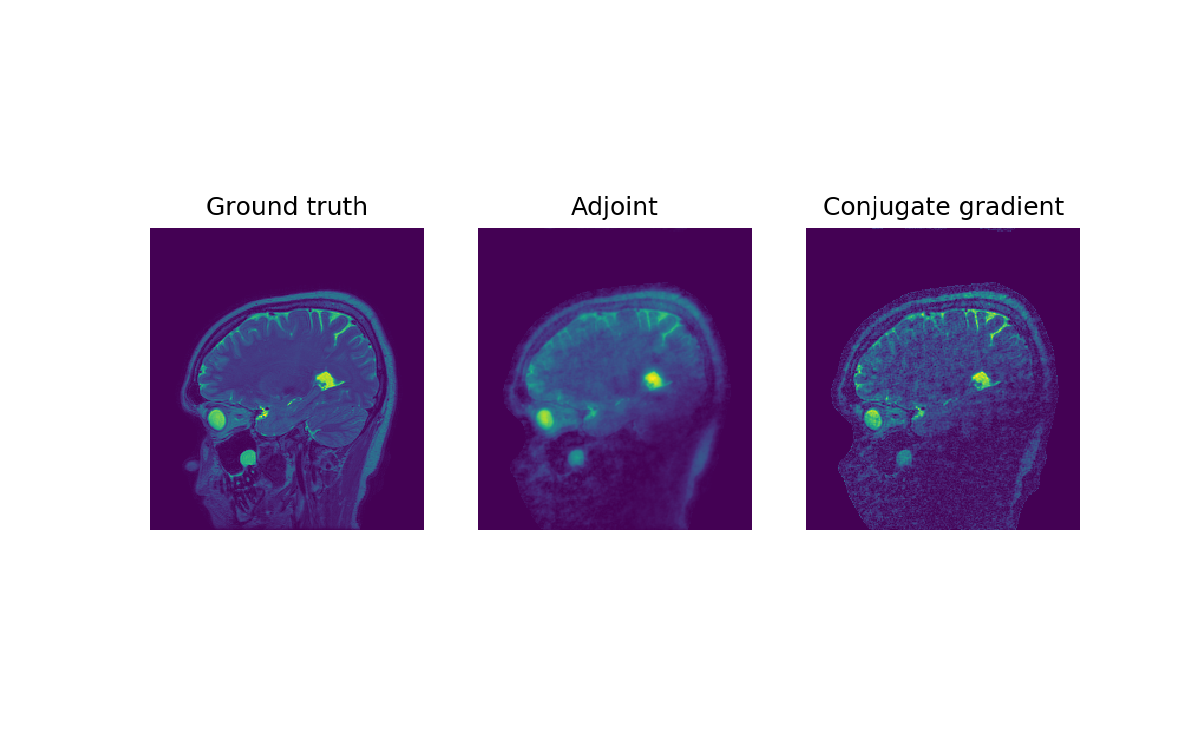

Text(0.5, 1.0, 'Conjugate gradient')

In [5]:
plt.figure(figsize=(8,5))
plt.subplot(131)
plt.imshow(getAbs(imgs_0[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Ground truth')
plt.subplot(132)
plt.imshow(getAbs(adjoint[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Adjoint')
plt.subplot(133)
plt.imshow(getAbs(recon[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Conjugate gradient')

## Forward Reverse test
prints the normalized rmse between input and reverse for different number of unrolled conjugate gradient iterations